In [42]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from gpflow.optimizers import Scipy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Toy example

In [36]:
def sample_icm_rbf(X, *, lengthscale=1.0, B=None, noise_variance=0.0, jitter=1e-6, random_state=None):

    X = np.asarray(X, dtype=float).reshape(-1, 1)
    n = X.shape[0]

    if B is None:
        B = np.array([[1.0, 0.7],
                      [0.7, 1.0]])

    # --- RBF kernel over inputs -------------------------------------------
    sq_dists = (X - X.T) ** 2
    Kx = np.exp(-0.5 * sq_dists / lengthscale ** 2)       # (n, n)

    # --- Full block covariance  K = B ⊗ Kx  -------------------------------
    K = np.kron(B, Kx)                                     # (2n, 2n)
    K += jitter * np.eye(K.shape[0])                       # numerical stab.

    # --- Draw one multivariate‑normal sample ------------------------------
    rng = np.random.default_rng(random_state)
    y = rng.multivariate_normal(np.zeros(K.shape[0]), K)   # latent f
    y = y.reshape(2, n).T                                  # (n, 2)

    # --- Add observation noise -------------------------------------------
    noise_variance = np.asarray(noise_variance, dtype=float)
    if noise_variance.ndim == 0:
        # same variance for both outputs
        y += rng.normal(scale=np.sqrt(noise_variance), size=y.shape)
    elif noise_variance.ndim == 1 and noise_variance.shape[0] == 2:
        # separate variance for each output
        scales = np.sqrt(noise_variance)[None, :]          # (1, 2)
        y += rng.normal(scale=scales, size=y.shape)
    else:
        raise ValueError("noise_variance must be a scalar or length‑2 array")

    return y 

def make_X_multi(X, D, *, start_from_zero=True):
    X = np.asarray(X).ravel()                 # (N,)
    N = X.size

    # Repeat inputs and build channel‑index column
    x_rep   = np.tile(X,  D)                  # (N*D,)
    channels = np.repeat(
        np.arange(D) + (0 if start_from_zero else 1),
        N
    )

    return np.column_stack((x_rep, channels)) # (N*D, 2)


Learned coregionalization parameters:
Coregionalization matrix B:
[[ 2.04628485 -0.43944686]
 [-0.43944686  0.51511482]]

Base kernel lengthscale: 0.6011077239751437


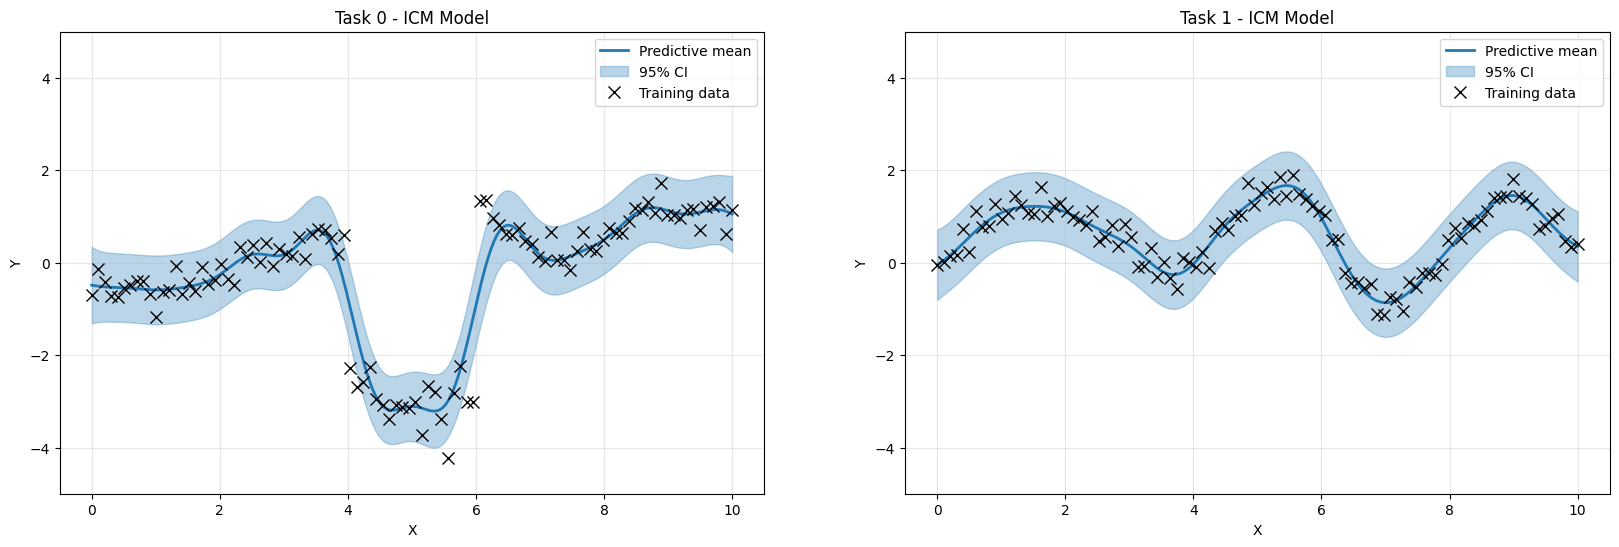

In [38]:
np.random.seed(42)
N = 100
D = 2

X = np.linspace(0.0, 10, N)
Y = sample_icm_rbf(X, lengthscale=1, noise_variance=0.05, random_state=41)

# Outliers
outlier_range = np.where((X >= 4) & (X <= 6))[0]
outlier_indices = np.random.choice(outlier_range, int(20), replace=False)
Y[outlier_indices, 0] = np.random.normal(loc=-3, scale=0.5, size=outlier_indices.shape[0])

X_multi = make_X_multi(X, D=D)
Y_multi = Y.reshape(-1, 1, order='F')

base_kernel = gpflow.kernels.RBF(lengthscales=1.0, variance=1.0, active_dims=[0])
coregion_kernel = gpflow.kernels.Coregion(output_dim=D, rank=D, active_dims=[1])

kernel = base_kernel * coregion_kernel

gpflow.utilities.set_trainable(base_kernel.variance, False)

likelihood_vgp = gpflow.likelihoods.StudentT()

model_vgp = gpflow.models.VGP(
    data=(X_multi, Y_multi),
    kernel=kernel,
    likelihood=likelihood_vgp
)

opt = Scipy()
def objective_closure_vgp():
    return -model_vgp.maximum_log_likelihood_objective()
opt.minimize(objective_closure_vgp, model_vgp.trainable_variables, options=dict(maxiter=1000))

# Print learned coregionalization matrix
print("\nLearned coregionalization parameters:")
print(f"Coregionalization matrix B:")
B_matrix = model_vgp.kernel.kernels[1].output_covariance()
print(B_matrix.numpy())

print(f"\nBase kernel lengthscale: {model_vgp.kernel.kernels[0].lengthscales.numpy()}")


plt.figure(figsize=(20, 6))
X_test = np.linspace(0, 10, 200).reshape(-1, 1)

# Plot predictions for each task
for task in range(D):
    # Get training data for this task
    idx = X_multi[:, 1] == task
    X_train_task = X_multi[idx, 0]
    Y_train_task = Y_multi[idx, 0]
    
    # Create test input with task index
    X_test_task = np.hstack([X_test, np.full((len(X_test), 1), task)])
    
    # Make predictions
    mean, var = model_vgp.predict_y(X_test_task)
    
    # Convert to numpy for plotting
    mean = mean.numpy()
    var = var.numpy()
    
    # Calculate confidence intervals
    lower = mean - 1.96 * np.sqrt(var)
    upper = mean + 1.96 * np.sqrt(var)
    
    # Plot
    plt.subplot(1, D, task + 1)
    plt.title(f"Task {task} - ICM Model")
    plt.plot(X_test.flatten(), mean.flatten(), 'C0', linewidth=2, label='Predictive mean')
    plt.fill_between(X_test.flatten(), lower.flatten(), upper.flatten(), 
                     color='C0', alpha=0.3, label='95% CI')
    plt.plot(X_train_task, Y_train_task, 'kx', markersize=8, label='Training data')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.ylim(-5,5)
    plt.legend()
    plt.grid(True, alpha=0.3)

In [3]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from gpflow.optimizers import Scipy

In [ ]:
np.random.seed(42)
n_points_per_task = 50
num_tasks = 2

# Generate example multi-task data
X_multi = []
Y_multi = []

for task in range(num_tasks):
    X_task = np.random.uniform(0, 10, n_points_per_task).reshape(-1, 1)
    # Different functions for different tasks
    if task == 0:
        Y_task = np.sin(X_task) + 0.1 * np.random.randn(n_points_per_task, 1)
    else:
        Y_task = np.cos(X_task) + 0.1 * np.random.randn(n_points_per_task, 1)
    
    # Add task index as second column
    X_task_with_index = np.hstack([X_task, np.full((n_points_per_task, 1), task)])
    
    X_multi.append(X_task_with_index)
    Y_multi.append(Y_task)

X_multi = np.vstack(X_multi)
Y_multi = np.vstack(Y_multi)

# Define Intrinsic Coregionalization Model (ICM) kernel
# This kernel allows for learning correlations between tasks

# Base kernel on input space (does not see task index)
# Fix variance at 1.0 to avoid identifiability issues with coregionalization matrix
base_kernel = gpflow.kernels.RBF(lengthscales=1.0, variance=1.0, active_dims=[0])

# Coregionalization kernel on task space
# This learns a positive semi-definite matrix B that captures task correlations
coregion_kernel = gpflow.kernels.Coregion(
    output_dim=num_tasks,  # Number of tasks
    rank=num_tasks,        # Rank of coregionalization matrix (can be < num_tasks for low-rank approximation)
    active_dims=[1]        # Operates on task dimension (column 1)
)

# ICM kernel: base_kernel ⊗ coregion_kernel
kernel = base_kernel * coregion_kernel

# Fix the base kernel variance to avoid identifiability issues
gpflow.utilities.set_trainable(base_kernel.variance, False)

# Or use a simpler approach with separate models per task
# Here's the corrected VGP model:

# Create the VGP model
likelihood_vgp = gpflow.likelihoods.StudentT()

model_vgp = gpflow.models.VGP(
    data=(X_multi, Y_multi),
    kernel=kernel,
    likelihood=likelihood_vgp
)

# Optional: fix noise variance
# model_vgp.likelihood.scale.assign(1e-4)

# Set up optimizer
opt = Scipy()

# Optimize - fixed variable names and objective function
def objective_closure_vgp():
    return -model_vgp.maximum_log_likelihood_objective()

# Run optimization
print("Optimizing ICM model...")
opt.minimize(objective_closure_vgp, model_vgp.trainable_variables, options=dict(maxiter=1000))

# Print learned coregionalization matrix
print("\nLearned coregionalization parameters:")
print(f"Coregionalization matrix B:")
B_matrix = model_vgp.kernel.kernels[1].output_covariance()
print(B_matrix.numpy())

print(f"\nBase kernel lengthscale: {model_vgp.kernel.kernels[0].lengthscales.numpy()}")
print(f"Base kernel variance (fixed): {model_vgp.kernel.kernels[0].variance.numpy()}")

# The coregionalization matrix shows how tasks are correlated
# Diagonal elements show task-specific variances
# Off-diagonal elements show inter-task correlations
print(f"\nNote: Base kernel variance is fixed at 1.0 to avoid identifiability issues")
print(f"All task variances and correlations are captured in the coregionalization matrix B")

# Plotting with improved visualization
plt.figure(figsize=(15, 10))

# Test inputs
X_test = np.linspace(0, 10, 200).reshape(-1, 1)

# Plot predictions for each task
for task in range(num_tasks):
    # Get training data for this task
    idx = X_multi[:, 1] == task
    X_train_task = X_multi[idx, 0]
    Y_train_task = Y_multi[idx, 0]
    
    # Create test input with task index
    X_test_task = np.hstack([X_test, np.full((len(X_test), 1), task)])
    
    # Make predictions
    mean, var = model_vgp.predict_y(X_test_task)
    
    # Convert to numpy for plotting
    mean = mean.numpy()
    var = var.numpy()
    
    # Calculate confidence intervals
    lower = mean - 1.96 * np.sqrt(var)
    upper = mean + 1.96 * np.sqrt(var)
    
    # Plot
    plt.subplot(2, num_tasks, task + 1)
    plt.title(f"Task {task} - ICM Model")
    plt.plot(X_test.flatten(), mean.flatten(), 'C0', linewidth=2, label='Predictive mean')
    plt.fill_between(X_test.flatten(), lower.flatten(), upper.flatten(), 
                     color='C0', alpha=0.3, label='95% CI')
    plt.plot(X_train_task, Y_train_task, 'kx', markersize=8, label='Training data')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True, alpha=0.3)

# Plot coregionalization matrix as heatmap
plt.subplot(2, 2, 3)
B_matrix = model_vgp.kernel.kernels[1].output_covariance().numpy()
im = plt.imshow(B_matrix, cmap='RdBu_r', aspect='auto')
plt.colorbar(im)
plt.title('Learned Coregionalization Matrix B')
plt.xlabel('Task')
plt.ylabel('Task')
for i in range(num_tasks):
    for j in range(num_tasks):
        plt.text(j, i, f'{B_matrix[i,j]:.3f}', ha='center', va='center')

# Plot cross-correlations
plt.subplot(2, 2, 4)
correlations = np.zeros((num_tasks, num_tasks))
for i in range(num_tasks):
    for j in range(num_tasks):
        correlations[i, j] = B_matrix[i, j] / np.sqrt(B_matrix[i, i] * B_matrix[j, j])

im = plt.imshow(correlations, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
plt.colorbar(im)
plt.title('Task Correlations')
plt.xlabel('Task')
plt.ylabel('Task')
for i in range(num_tasks):
    for j in range(num_tasks):
        plt.text(j, i, f'{correlations[i,j]:.3f}', ha='center', va='center')

plt.tight_layout()
plt.show()

# Additional analysis: show how information is shared between tasks
print(f"\nTask correlations:")
for i in range(num_tasks):
    for j in range(i+1, num_tasks):
        corr = correlations[i, j]
        if corr > 0.1:
            print(f"Task {i} and Task {j} are positively correlated (ρ = {corr:.3f})")
        elif corr < -0.1:
            print(f"Task {i} and Task {j} are negatively correlated (ρ = {corr:.3f})")
        else:
            print(f"Task {i} and Task {j} have weak correlation (ρ = {corr:.3f})")


# Example of using the ICM model for transfer learning
print("\n" + "="*50)
print("TRANSFER LEARNING EXAMPLE")
print("="*50)

# Simulate a scenario where we have more data for task 0 than task 1
print("Simulating transfer learning scenario...")
print("- Task 0: Many training points")
print("- Task 1: Few training points")
print("- ICM should help Task 1 learn from Task 0")

# Create new dataset with imbalanced data
np.random.seed(123)
n_points_task0 = 100  # Lots of data
n_points_task1 = 10   # Little data

X_transfer = []
Y_transfer = []

# Task 0: lots of data
X_task0 = np.random.uniform(0, 10, n_points_task0).reshape(-1, 1)
Y_task0 = np.sin(X_task0) + 0.1 * np.random.randn(n_points_task0, 1)
X_task0_with_index = np.hstack([X_task0, np.full((n_points_task0, 1), 0)])
X_transfer.append(X_task0_with_index)
Y_transfer.append(Y_task0)

# Task 1: little data, but related function
X_task1 = np.random.uniform(0, 10, n_points_task1).reshape(-1, 1)
Y_task1 = np.sin(X_task1 + 0.5) + 0.1 * np.random.randn(n_points_task1, 1)  # Similar but shifted
X_task1_with_index = np.hstack([X_task1, np.full((n_points_task1, 1), 1)])
X_transfer.append(X_task1_with_index)
Y_transfer.append(Y_task1)

X_transfer = np.vstack(X_transfer)
Y_transfer = np.vstack(Y_transfer)

# Train ICM model on transfer learning data
base_kernel_transfer = gpflow.kernels.RBF(lengthscales=1.0, variance=1.0, active_dims=[0])
coregion_kernel_transfer = gpflow.kernels.Coregion(
    output_dim=2,
    rank=2,
    active_dims=[1]
)
kernel_transfer = base_kernel_transfer * coregion_kernel_transfer

# Fix the base kernel variance for transfer learning model too
gpflow.utilities.set_trainable(base_kernel_transfer.variance, False)

model_transfer = gpflow.models.VGP(
    data=(X_transfer, Y_transfer),
    kernel=kernel_transfer,
    likelihood=gpflow.likelihoods.StudentT()
)

def objective_closure_transfer():
    return -model_transfer.maximum_log_likelihood_objective()

print("Training transfer learning model...")
opt.minimize(objective_closure_transfer, model_transfer.trainable_variables, 
            options=dict(maxiter=1000))

# Compare with independent models
print("Training independent models for comparison...")
independent_models = {}
for task in range(2):
    idx = X_transfer[:, 1] == task
    X_indep = X_transfer[idx, 0:1]
    Y_indep = Y_transfer[idx]
    
    if len(X_indep) > 0:  # Only train if we have data
        model_indep = gpflow.models.VGP(
            data=(X_indep, Y_indep),
            kernel=gpflow.kernels.RBF(lengthscales=1.0),
            likelihood=gpflow.likelihoods.StudentT()
        )
        
        def objective_closure_indep():
            return -model_indep.maximum_log_likelihood_objective()
        
        opt.minimize(objective_closure_indep, model_indep.trainable_variables, 
                    options=dict(maxiter=1000))
        independent_models[task] = model_indep

# Plot comparison
plt.figure(figsize=(15, 5))

X_test = np.linspace(0, 10, 200).reshape(-1, 1)

for task in range(2):
    idx = X_transfer[:, 1] == task
    X_train_task = X_transfer[idx, 0]
    Y_train_task = Y_transfer[idx, 0]
    
    plt.subplot(1, 3, task + 1)
    
    # ICM predictions
    X_test_task = np.hstack([X_test, np.full((len(X_test), 1), task)])
    mean_icm, var_icm = model_transfer.predict_y(X_test_task)
    mean_icm, var_icm = mean_icm.numpy(), var_icm.numpy()
    
    plt.plot(X_test.flatten(), mean_icm.flatten(), 'C0', linewidth=2, label='ICM')
    plt.fill_between(X_test.flatten(), 
                     (mean_icm - 1.96 * np.sqrt(var_icm)).flatten(),
                     (mean_icm + 1.96 * np.sqrt(var_icm)).flatten(),
                     color='C0', alpha=0.3)
    
    # Independent model predictions (if available)
    if task in independent_models:
        mean_indep, var_indep = independent_models[task].predict_y(X_test)
        mean_indep, var_indep = mean_indep.numpy(), var_indep.numpy()
        
        plt.plot(X_test.flatten(), mean_indep.flatten(), 'C1', linewidth=2, label='Independent')
        plt.fill_between(X_test.flatten(), 
                         (mean_indep - 1.96 * np.sqrt(var_indep)).flatten(),
                         (mean_indep + 1.96 * np.sqrt(var_indep)).flatten(),
                         color='C1', alpha=0.3)
    
    plt.plot(X_train_task, Y_train_task, 'kx', markersize=8, label=f'Training data (n={len(X_train_task)})')
    plt.title(f'Task {task} - Transfer Learning')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Show coregionalization matrix
plt.subplot(1, 3, 3)
B_transfer = model_transfer.kernel.kernels[1].output_covariance().numpy()
im = plt.imshow(B_transfer, cmap='RdBu_r', aspect='auto')
plt.colorbar(im)
plt.title('Transfer Learning\nCoregionalization Matrix')
plt.xlabel('Task')
plt.ylabel('Task')
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{B_transfer[i,j]:.3f}', ha='center', va='center')

plt.tight_layout()
plt.show()

print(f"\nTransfer learning coregionalization matrix:")
print(B_transfer)
corr_transfer = B_transfer[0,1] / np.sqrt(B_transfer[0,0] * B_transfer[1,1])
print(f"Task correlation: {corr_transfer:.3f}")
print(f"This shows how much Task 1 (few data) benefits from Task 0 (lots of data)")

# Energy efficiency dataset

In [64]:
import pandas as pd

# URL of the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Read Excel file directly from the URL
df = pd.read_excel(url)

# Extract covariates X (columns X1 to X8)
X = df.loc[:, 'X1':'X8']

# Extract target variables Y (columns Y1 and Y2)
Y = df.loc[:, ['Y1', 'Y2']]

In [65]:
# Split data into train and test sets (default test size = 25%)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.5, random_state=42
)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("Y_train shape:", Y_train_scaled.shape)
print("Y_test shape:", Y_test_scaled.shape)

X_train shape: (384, 8)
X_test shape: (384, 8)
Y_train shape: (384, 2)
Y_test shape: (384, 2)


In [ ]:
# Create multi-task inputs
X_multi_train = make_X_multi(X_train_scaled, D=2)
X_multi_test = make_X_multi(X_test_scaled, D=2)
Y_multi_train = Y_train_scaled.reshape(-1, 1, order='F')
Y_multi_test = Y_test_scaled.reshape(-1, 1, order='F')

input_dim = X_train_scaled.shape[1]  # This is the key fix!
N = X_train_scaled.shape[0]
D = 2

base_kernel = gpflow.kernels.RBF(
    lengthscales=np.ones(input_dim), 
    variance=1.0, 
    active_dims=list(range(input_dim)) 
)

coregion_kernel = gpflow.kernels.Coregion(
    output_dim=D, 
    rank=D, 
    active_dims=[input_dim]  
)

kernel = base_kernel * coregion_kernel

gpflow.utilities.set_trainable(base_kernel.variance, False)

likelihood_vgp = gpflow.likelihoods.StudentT()
model_vgp = gpflow.models.VGP(
    data=(X_multi_train, Y_multi_train),
    kernel=kernel,
    likelihood=likelihood_vgp
)

opt = Scipy()
def objective_closure_vgp():
    return -model_vgp.maximum_log_likelihood_objective()

try:
    opt.minimize(objective_closure_vgp, model_vgp.trainable_variables, options=dict(maxiter=1000))
except Exception as e:
    print(f"Optimization failed: {e}")
    print("Try reducing maxiter or checking data shapes")

mean_pred, var_pred = model_vgp.predict_y(X_multi_test)
mean_pred_np, var_pred_np = mean_pred.numpy(), var_pred.numpy()

X_multi_train shape: (768, 9)
X_multi_test shape: (768, 9)
Task indices range: 0.0 to 1.0
Unique task indices: [0. 1.]
Starting optimization...
Optimization completed successfully!


# Trash

In [69]:

# Predict mean and variance using the trained VGP model
print("=== Making Predictions ===")
print(f"X_multi_test shape: {X_multi_test.shape}")

# Get predictions from the model
# For VGP models, predict_f returns mean and variance
mean_pred, var_pred = model_vgp.predict_y(X_multi_test)

print(f"Predicted mean shape: {mean_pred.shape}")
print(f"Predicted variance shape: {var_pred.shape}")

# Convert to numpy arrays for easier handling
mean_pred_np = mean_pred.numpy()
var_pred_np = var_pred.numpy()

print(f"Mean predictions (first 10): {mean_pred_np[:10].flatten()}")
print(f"Variance predictions (first 10): {var_pred_np[:10].flatten()}")

=== Making Predictions ===
X_multi_test shape: (768, 9)
Predicted mean shape: (768, 1)
Predicted variance shape: (768, 1)
Mean predictions (first 10): [-0.53798449 -0.9426477   1.04209422  1.93659452 -0.5116639   0.11268966
  0.19052032  0.65827286 -0.26070814  0.6756783 ]
Variance predictions (first 10): [0.01057459 0.01020374 0.01036512 0.01024116 0.00987479 0.01041616
 0.01014016 0.01009879 0.01099792 0.01065973]


In [70]:
# Calculate Mean Squared Error
print("\n=== Mean Squared Error Calculation ===")
print(f"Y_multi_test shape: {Y_multi_test.shape}")

# Calculate MSE
mse = np.mean((mean_pred_np - Y_multi_test)**2)
print(f"Overall MSE: {mse:.6f}")

# Calculate RMSE for easier interpretation
rmse = np.sqrt(mse)
print(f"Overall RMSE: {rmse:.6f}")

# Calculate MSE by task
task_indices_test = X_multi_test[:, -1]
unique_tasks = np.unique(task_indices_test)

print(f"\nMSE by task:")
for task_id in unique_tasks:
    task_mask = task_indices_test == task_id
    task_mean_pred = mean_pred_np[task_mask]
    task_y_test = Y_multi_test[task_mask]
    
    task_mse = np.mean((task_mean_pred - task_y_test)**2)
    task_rmse = np.sqrt(task_mse)
    
    print(f"Task {int(task_id)}:")
    print(f"  - MSE: {task_mse:.6f}")
    print(f"  - RMSE: {task_rmse:.6f}")
    print(f"  - Number of test points: {len(task_mean_pred)}")

# Additional metrics
print(f"\n=== Additional Metrics ===")
mae = np.mean(np.abs(mean_pred_np - Y_multi_test))
print(f"Mean Absolute Error (MAE): {mae:.6f}")

# R-squared
ss_res = np.sum((Y_multi_test - mean_pred_np)**2)
ss_tot = np.sum((Y_multi_test - np.mean(Y_multi_test))**2)
r2 = 1 - (ss_res / ss_tot)
print(f"R-squared: {r2:.6f}")

print("MSE calculation completed!")


=== Mean Squared Error Calculation ===
Y_multi_test shape: (768, 1)
Overall MSE: 0.026864
Overall RMSE: 0.163903

MSE by task:
Task 0:
  - MSE: 0.007878
  - RMSE: 0.088756
  - Number of test points: 384
Task 1:
  - MSE: 0.045851
  - RMSE: 0.214128
  - Number of test points: 384

=== Additional Metrics ===
Mean Absolute Error (MAE): 0.086803
R-squared: 0.973887
MSE calculation completed!


In [59]:
Y_multi_test

array([[-0.57017686],
       [-0.89977479],
       [ 1.06283109],
       [ 1.91179547],
       [-0.54820366],
       [ 0.16193007],
       [ 0.21286793],
       [ 0.64833672],
       [-0.26554846],
       [ 0.58840982],
       [-0.37141931],
       [ 1.08879941],
       [ 0.76020026],
       [-1.17943364],
       [-0.4483255 ],
       [ 1.4753279 ],
       [ 1.44436567],
       [-0.98666879],
       [-0.7469612 ],
       [ 1.0188847 ],
       [ 0.64833672],
       [ 1.91978572],
       [-1.04659569],
       [ 1.46633887],
       [-0.68004283],
       [ 1.36945705],
       [ 1.4373742 ],
       [ 0.67230748],
       [-0.46730235],
       [-0.8178747 ],
       [-1.17443974],
       [-0.98666879],
       [-0.5242329 ],
       [ 0.46555968],
       [ 1.37445096],
       [ 0.59939642],
       [ 1.05284328],
       [ 1.47033399],
       [ 1.38643634],
       [-1.14647385],
       [ 0.59640008],
       [-0.98467123],
       [-1.57934581],
       [ 0.96495049],
       [-1.53699746],
       [-1

In [61]:
# Quick debugging and fix for standard GP implementation

# First, debug your data shapes
print("=== Debugging Data Shapes ===")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"Y_multi shape: {Y_multi.shape}")

# Get actual input dimension from your data
actual_input_dim = X_train_scaled.shape[1]
print(f"Actual input dimension: {actual_input_dim}")

# Create multi-task inputs
X_multi_train = make_X_multi(X_train_scaled, D=2)
X_multi_test = make_X_multi(X_test_scaled, D=2)
Y_multi_train = Y_train_scaled.reshape(-1, 1, order='F')
Y_multi_test = Y_test_scaled.reshape(-1, 1, order='F')

print(f"X_multi_train shape: {X_multi_train.shape}")
print(f"X_multi_test shape: {X_multi_test.shape}")

# Check task indices
task_indices = X_multi_train[:, -1]
print(f"Task indices range: {task_indices.min()} to {task_indices.max()}")
print(f"Unique task indices: {np.unique(task_indices)}")

# FIXED: Use actual_input_dim instead of hardcoded 8
input_dim = actual_input_dim  # This is the key fix!
N = X_train_scaled.shape[0]
D = 2

# The base kernel now operates on the actual input dimensions
# Using a single shared lengthscale for all dimensions
base_kernel = gpflow.kernels.RBF(
    lengthscales=1.0,  # Single shared lengthscale
    variance=1.0, 
    active_dims=list(range(input_dim))  # [0, 1, 2, ..., input_dim-1]
)

# Coregionalization kernel operates on the task dimension
coregion_kernel = gpflow.kernels.Coregion(
    output_dim=D, 
    rank=D, 
    active_dims=[input_dim]  # Task index is at position input_dim
)

kernel = base_kernel * coregion_kernel

# Fix base kernel variance
gpflow.utilities.set_trainable(base_kernel.variance, False)

# Create standard GP model (GPR instead of VGP)
model_gpr = gpflow.models.GPR(
    data=(X_multi_train, Y_multi_train),
    kernel=kernel
)

# For GPR, we can set the likelihood variance if needed
# model_gpr.likelihood.variance.assign(0.1)  # Uncomment if you want to set initial noise

# Optimization for standard GP
opt = Scipy()
def objective_closure_gpr():
    return -model_gpr.log_marginal_likelihood()

print("Starting optimization...")
try:
    opt.minimize(objective_closure_gpr, model_gpr.trainable_variables, options=dict(maxiter=1000))
    print("Optimization completed successfully!")
except Exception as e:
    print(f"Optimization failed: {e}")
    print("Try reducing maxiter or checking data shapes")

# Print final hyperparameters
print("\n=== Final Hyperparameters ===")
print(f"Base kernel lengthscale: {base_kernel.lengthscales.numpy()}")  # Single value now
print(f"Base kernel variance: {base_kernel.variance.numpy()}")
print(f"Coregion kernel W: {coregion_kernel.W.numpy()}")
print(f"Coregion kernel kappa: {coregion_kernel.kappa.numpy()}")
print(f"Likelihood variance: {model_gpr.likelihood.variance.numpy()}")

# Make predictions
print("\n=== Making Predictions ===")
mean_pred, var_pred = model_gpr.predict_f(X_multi_test)
print(f"Prediction mean shape: {mean_pred.shape}")
print(f"Prediction variance shape: {var_pred.shape}")

# If you want predictive distribution (including noise)
mean_pred_y, var_pred_y = model_gpr.predict_y(X_multi_test)
print(f"Predictive mean shape: {mean_pred_y.shape}")
print(f"Predictive variance shape: {var_pred_y.shape}")


=== Debugging Data Shapes ===
X_train_scaled shape: (384, 8)
Y_multi shape: (200, 1)
Actual input dimension: 8
X_multi_train shape: (768, 9)
X_multi_test shape: (768, 9)
Task indices range: 0.0 to 1.0
Unique task indices: [0. 1.]
Starting optimization...
Optimization completed successfully!

=== Final Hyperparameters ===
Base kernel lengthscale: 1.6777600438196303
Base kernel variance: 0.9999999999999999
Coregion kernel W: [[0.85875228 0.85875228]
 [1.05275154 1.05275154]]
Coregion kernel kappa: [0.06815606 0.09261355]
Likelihood variance: 0.007192620943758054

=== Making Predictions ===
Prediction mean shape: (768, 1)
Prediction variance shape: (768, 1)
Predictive mean shape: (768, 1)
Predictive variance shape: (768, 1)


In [63]:
# Quick debugging and fix for standard GP implementation

# First, debug your data shapes
print("=== Debugging Data Shapes ===")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"Y_multi shape: {Y_multi.shape}")

# Get actual input dimension from your data
actual_input_dim = X_train_scaled.shape[1]
print(f"Actual input dimension: {actual_input_dim}")

# Create multi-task inputs
X_multi_train = make_X_multi(X_train_scaled, D=2)
X_multi_test = make_X_multi(X_test_scaled, D=2)
Y_multi_train = Y_train_scaled.reshape(-1, 1, order='F')
Y_multi_test = Y_test_scaled.reshape(-1, 1, order='F')

print(f"X_multi_train shape: {X_multi_train.shape}")
print(f"X_multi_test shape: {X_multi_test.shape}")

# Check task indices
task_indices = X_multi_train[:, -1]
print(f"Task indices range: {task_indices.min()} to {task_indices.max()}")
print(f"Unique task indices: {np.unique(task_indices)}")

# FIXED: Use actual_input_dim instead of hardcoded 8
input_dim = actual_input_dim  # This is the key fix!
N = X_train_scaled.shape[0]
D = 2

# The base kernel now operates on the actual input dimensions
# Using a single shared lengthscale for all dimensions
base_kernel = gpflow.kernels.RBF(
    lengthscales=1.0,  # Single shared lengthscale
    variance=1.0, 
    active_dims=list(range(input_dim))  # [0, 1, 2, ..., input_dim-1]
)

# Coregionalization kernel operates on the task dimension
coregion_kernel = gpflow.kernels.Coregion(
    output_dim=D, 
    rank=D, 
    active_dims=[input_dim]  # Task index is at position input_dim
)

kernel = base_kernel * coregion_kernel

# Fix base kernel variance
gpflow.utilities.set_trainable(base_kernel.variance, False)

# Create standard GP model (GPR instead of VGP)
model_gpr = gpflow.models.GPR(
    data=(X_multi_train, Y_multi_train),
    kernel=kernel
)

# For GPR, we can set the likelihood variance if needed
# model_gpr.likelihood.variance.assign(0.1)  # Uncomment if you want to set initial noise

# Optimization for standard GP
opt = Scipy()
def objective_closure_gpr():
    return -model_gpr.log_marginal_likelihood()

print("Starting optimization...")
try:
    opt.minimize(objective_closure_gpr, model_gpr.trainable_variables, options=dict(maxiter=1000))
    print("Optimization completed successfully!")
except Exception as e:
    print(f"Optimization failed: {e}")
    print("Try reducing maxiter or checking data shapes")

# Print final hyperparameters
print("\n=== Final Hyperparameters ===")
print(f"Base kernel lengthscale: {base_kernel.lengthscales.numpy()}")  # Single value now
print(f"Base kernel variance: {base_kernel.variance.numpy()}")
print(f"Coregion kernel W: {coregion_kernel.W.numpy()}")
print(f"Coregion kernel kappa: {coregion_kernel.kappa.numpy()}")
print(f"Likelihood variance: {model_gpr.likelihood.variance.numpy()}")

# Make predictions
print("\n=== Making Predictions ===")
mean_pred, var_pred = model_gpr.predict_f(X_multi_test)
print(f"Prediction mean shape: {mean_pred.shape}")
print(f"Prediction variance shape: {var_pred.shape}")

# If you want predictive distribution (including noise)
mean_pred_y, var_pred_y = model_gpr.predict_y(X_multi_test)
print(f"Predictive mean shape: {mean_pred_y.shape}")
print(f"Predictive variance shape: {var_pred_y.shape}")

# Convert predictions to numpy for MSE calculation
mean_pred_np = mean_pred.numpy()

# Calculate Mean Squared Error
print("\n=== Mean Squared Error Calculation ===")
print(f"Y_multi_test shape: {Y_multi_test.shape}")

# Calculate MSE
mse = np.mean((mean_pred_np - Y_multi_test)**2)
print(f"Overall MSE: {mse:.6f}")

# Calculate RMSE for easier interpretation
rmse = np.sqrt(mse)
print(f"Overall RMSE: {rmse:.6f}")

# Calculate MSE by task
task_indices_test = X_multi_test[:, -1]
unique_tasks = np.unique(task_indices_test)

print(f"\nMSE by task:")
for task_id in unique_tasks:
    task_mask = task_indices_test == task_id
    task_mean_pred = mean_pred_np[task_mask]
    task_y_test = Y_multi_test[task_mask]
    
    task_mse = np.mean((task_mean_pred - task_y_test)**2)
    task_rmse = np.sqrt(task_mse)
    
    print(f"Task {int(task_id)}:")
    print(f"  - MSE: {task_mse:.6f}")
    print(f"  - RMSE: {task_rmse:.6f}")
    print(f"  - Number of test points: {len(task_mean_pred)}")

# Additional metrics
print(f"\n=== Additional Metrics ===")
mae = np.mean(np.abs(mean_pred_np - Y_multi_test))
print(f"Mean Absolute Error (MAE): {mae:.6f}")

# R-squared
ss_res = np.sum((Y_multi_test - mean_pred_np)**2)
ss_tot = np.sum((Y_multi_test - np.mean(Y_multi_test))**2)
r2 = 1 - (ss_res / ss_tot)
print(f"R-squared: {r2:.6f}")

print("MSE calculation completed!")

=== Debugging Data Shapes ===
X_train_scaled shape: (384, 8)
Y_multi shape: (200, 1)
Actual input dimension: 8
X_multi_train shape: (768, 9)
X_multi_test shape: (768, 9)
Task indices range: 0.0 to 1.0
Unique task indices: [0. 1.]
Starting optimization...
Optimization completed successfully!

=== Final Hyperparameters ===
Base kernel lengthscale: 1.6777600438196303
Base kernel variance: 0.9999999999999999
Coregion kernel W: [[0.85875228 0.85875228]
 [1.05275154 1.05275154]]
Coregion kernel kappa: [0.06815606 0.09261355]
Likelihood variance: 0.007192620943758054

=== Making Predictions ===
Prediction mean shape: (768, 1)
Prediction variance shape: (768, 1)
Predictive mean shape: (768, 1)
Predictive variance shape: (768, 1)

=== Mean Squared Error Calculation ===
Y_multi_test shape: (768, 1)
Overall MSE: 0.020526
Overall RMSE: 0.143269

MSE by task:
Task 0:
  - MSE: 0.010031
  - RMSE: 0.100153
  - Number of test points: 384
Task 1:
  - MSE: 0.031021
  - RMSE: 0.176129
  - Number of test p